iter    1 | total 7.914e-01 | data 1.171e-01 | ic 4.204e-01 | bc 8.127e-02 | pde 1.727e-01
iter  250 | total 4.642e-03 | data 2.596e-04 | ic 1.098e-03 | bc 4.479e-04 | pde 2.837e-03
iter  500 | total 3.625e-03 | data 1.013e-03 | ic 8.494e-04 | bc 8.679e-04 | pde 8.946e-04
iter  750 | total 1.029e-03 | data 2.104e-04 | ic 2.090e-04 | bc 2.828e-04 | pde 3.266e-04
iter 1000 | total 7.009e-04 | data 1.566e-04 | ic 1.132e-04 | bc 1.867e-04 | pde 2.445e-04
Training done in 2.5s


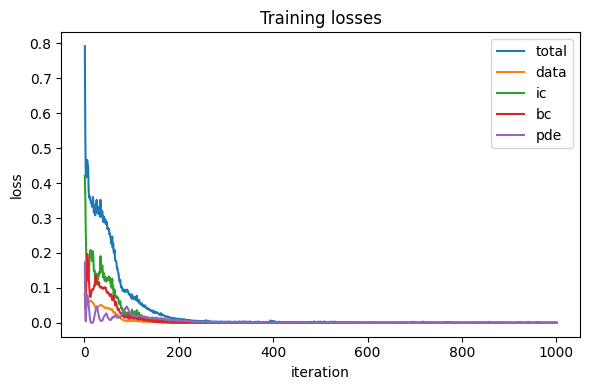

MSE at t=0.5 (normalized): 4.481e-04
IC MSE (normalized): 4.501e-04
BC MSE (normalized): 4.216e-03


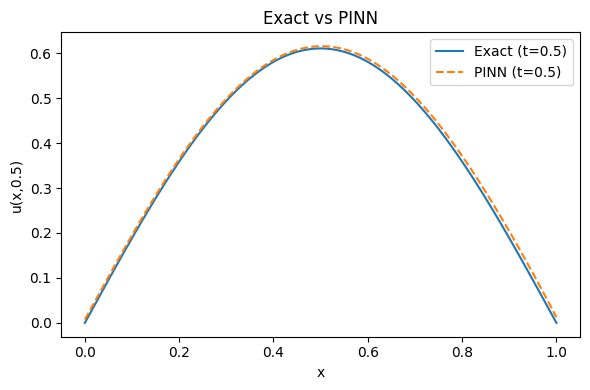


=== Training: full ===
iter    1 | total 5.420e-01 | data 8.720e-02 | ic 3.145e-01 | bc 8.715e-02 | pde 5.316e-02
iter  500 | total 1.757e-03 | data 4.054e-04 | ic 4.313e-04 | bc 5.712e-04 | pde 3.485e-04
iter 1000 | total 8.127e-04 | data 2.107e-04 | ic 1.070e-04 | bc 2.999e-04 | pde 1.951e-04
Training done in 2.6s

=== Training: no_ic ===
iter    1 | total 4.842e-01 | data 1.413e-01 | ic 0.000e+00 | bc 9.770e-02 | pde 2.453e-01
iter  500 | total 8.123e-04 | data 3.334e-04 | ic 0.000e+00 | bc 2.432e-04 | pde 2.357e-04
iter 1000 | total 6.673e-04 | data 3.505e-04 | ic 0.000e+00 | bc 1.862e-04 | pde 1.306e-04
Training done in 2.3s

=== Training: no_bc ===
iter    1 | total 6.865e-01 | data 1.766e-01 | ic 4.935e-01 | bc 0.000e+00 | pde 1.648e-02
iter  500 | total 7.342e-04 | data 2.760e-04 | ic 2.572e-04 | bc 0.000e+00 | pde 2.009e-04
iter 1000 | total 5.372e-04 | data 2.823e-04 | ic 1.591e-04 | bc 0.000e+00 | pde 9.584e-05
Training done in 2.3s

=== Training: no_ic_bc ===
iter    1 | t

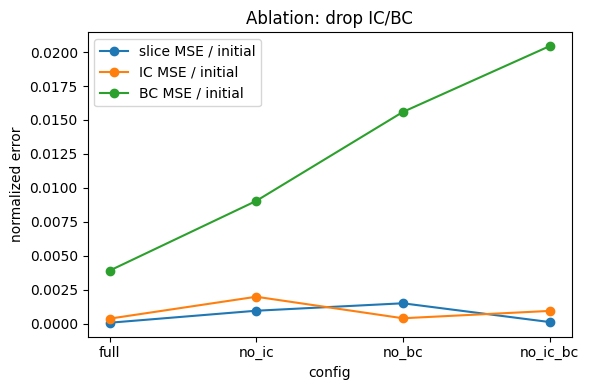


=== N_d=50, noise=0.0 ===
iter    1 | total 9.624e-01 | data 2.177e-01 | ic 6.555e-01 | bc 1.581e-02 | pde 7.334e-02
iter  400 | total 2.905e-03 | data 1.955e-04 | ic 6.382e-04 | bc 7.843e-04 | pde 1.287e-03
iter  800 | total 1.409e-03 | data 1.802e-04 | ic 3.612e-04 | bc 4.115e-04 | pde 4.561e-04
Training done in 2.0s

=== N_d=50, noise=0.01 ===
iter    1 | total 6.261e-01 | data 1.895e-01 | ic 4.039e-01 | bc 2.244e-02 | pde 1.027e-02
iter  400 | total 2.060e-03 | data 4.063e-04 | ic 4.728e-04 | bc 6.966e-04 | pde 4.847e-04
iter  800 | total 1.982e-03 | data 6.645e-04 | ic 3.267e-04 | bc 6.766e-04 | pde 3.137e-04
Training done in 1.9s

=== N_d=50, noise=0.05 ===
iter    1 | total 7.967e-01 | data 2.414e-01 | ic 5.529e-01 | bc 6.010e-04 | pde 1.734e-03
iter  400 | total 4.223e-03 | data 2.779e-03 | ic 3.531e-04 | bc 4.783e-04 | pde 6.129e-04
iter  800 | total 3.759e-03 | data 2.746e-03 | ic 2.151e-04 | bc 3.249e-04 | pde 4.724e-04
Training done in 1.9s

=== N_d=200, noise=0.0 ===
iter

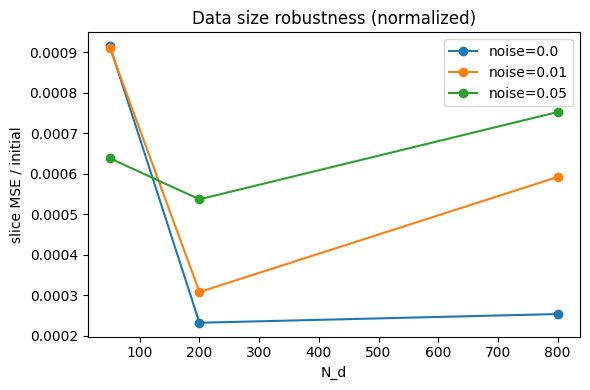

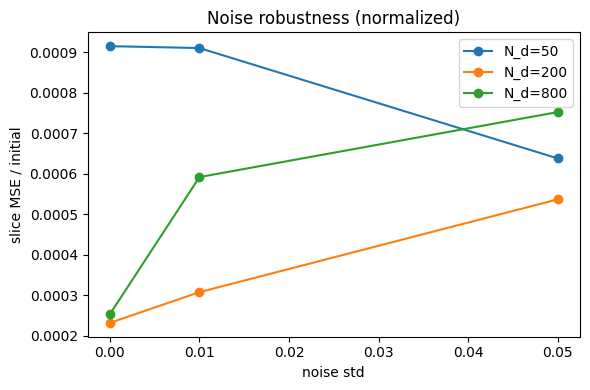

Saved: pinn_ablation_results_normalized.csv, pinn_sweep_results_normalized.csv


In [1]:
# PINNs — Robustness Experiments (1D Heat Equation)

# This notebook performs numerical experiments with a Physics-Informed Neural Network (PINN)
# on the 1D heat equation:
#
#   u_t = alpha * u_xx,  x in [0,1],  t in [0,1]
#
# with IC: u(x,0)=sin(pi x) and BCs: u(0,t)=u(1,t)=0.
# The exact solution is u(x,t)=exp(-alpha*pi^2*t)*sin(pi*x).
#
# We test robustness to:
# 1. Dropping IC/BC terms from the loss.
# 2. Number of datapoints and noise magnitude.

import math
import numpy as np
import torch
import torch.nn as nn
import torch.autograd as autograd
import matplotlib.pyplot as plt
import time
from dataclasses import dataclass
import pandas as pd

torch.manual_seed(0)
np.random.seed(0)
device = torch.device("cpu")

pi = math.pi
alpha = 0.1  # thermal diffusivity


def u_exact(x, t, alpha=alpha):
    return torch.exp(-alpha * (pi**2) * t) * torch.sin(pi * x)


# --- Sampling Functions ---
def make_supervised_data(n_d=200, noise_std=0.0):
    x = torch.rand(n_d, 1, device=device)
    t = torch.rand(n_d, 1, device=device)
    u = u_exact(x, t)
    if noise_std > 0:
        u = u + noise_std * torch.randn_like(u)
    return x, t, u


def sample_collocation(n_f=1000):
    x = torch.rand(n_f, 1, device=device, requires_grad=True)
    t = torch.rand(n_f, 1, device=device, requires_grad=True)
    return x, t


def sample_ic(n_ic=200):
    x = torch.rand(n_ic, 1, device=device)
    t = torch.zeros_like(x)
    u0 = torch.sin(pi * x)
    return x, t, u0


def sample_bc(n_bc=200):
    n0 = n_bc // 2
    t0 = torch.rand(n0, 1, device=device)
    x0 = torch.zeros_like(t0)
    u0 = torch.zeros_like(t0)
    
    t1 = torch.rand(n_bc - n0, 1, device=device)
    x1 = torch.ones_like(t1)
    u1 = torch.zeros_like(t1)
    
    x = torch.cat([x0, x1], 0)
    t = torch.cat([t0, t1], 0)
    u = torch.cat([u0, u1], 0)
    return x, t, u


# --- Model ---
class MLP(nn.Module):
    def __init__(self, width=64, depth=4):
        super().__init__()
        layers = [nn.Linear(2, width), nn.Tanh()]
        for _ in range(depth - 1):
            layers += [nn.Linear(width, width), nn.Tanh()]
        layers += [nn.Linear(width, 1)]
        self.net = nn.Sequential(*layers)
        for m in self.net:
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x, t):
        return self.net(torch.cat([x, t], dim=1))


# --- PDE Residual ---
def pde_residual(model, x, t):
    u = model(x, t)
    du_dx = autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
    du_dt = autograd.grad(u, t, torch.ones_like(u), create_graph=True)[0]
    d2u_dx2 = autograd.grad(du_dx, x, torch.ones_like(du_dx), create_graph=True)[0]
    return du_dt - alpha * d2u_dx2


# --- Training ---
@dataclass
class TrainCfg:
    iters: int = 2000
    lr: float = 1e-3
    n_f: int = 1000
    n_ic: int = 200
    n_bc: int = 200
    n_d: int = 200
    noise_std: float = 0.0
    lam_phys: float = 1.0
    lam_ic: float = 1.0
    lam_bc: float = 1.0
    lam_pde: float = 1.0
    width: int = 64
    depth: int = 4


def train_pinn(cfg: TrainCfg, verbose_every=500):
    model = MLP(width=cfg.width, depth=cfg.depth).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=cfg.lr)

    xd, td, ud = make_supervised_data(cfg.n_d, cfg.noise_std)
    hist = []

    t0 = time.time()
    for it in range(1, cfg.iters + 1):
        opt.zero_grad()
        xf, tf = sample_collocation(cfg.n_f)
        xi, ti, ui = sample_ic(cfg.n_ic)
        xb, tb, ub = sample_bc(cfg.n_bc)

        ud_pred = model(xd, td)
        L_data = ((ud_pred - ud)**2).mean()

        L_ic = ((model(xi, ti) - ui)**2).mean() if cfg.lam_ic != 0 else torch.tensor(0.0, device=device)
        L_bc = ((model(xb, tb) - ub)**2).mean() if cfg.lam_bc != 0 else torch.tensor(0.0, device=device)
        r = pde_residual(model, xf, tf)
        L_pde = (r**2).mean() if cfg.lam_pde != 0 else torch.tensor(0.0, device=device)

        L_phys = cfg.lam_ic*L_ic + cfg.lam_bc*L_bc + cfg.lam_pde*L_pde
        loss = L_data + cfg.lam_phys*L_phys

        loss.backward()
        opt.step()

        hist.append([it, loss.item(), L_data.item(), L_ic.item(), L_bc.item(), L_pde.item()])
        if verbose_every and (it % verbose_every == 0 or it == 1):
            print(f"iter {it:4d} | total {loss.item():.3e} | data {L_data.item():.3e} | ic {L_ic.item():.3e} | bc {L_bc.item():.3e} | pde {L_pde.item():.3e}")

    print(f"Training done in {time.time() - t0:.1f}s")
    hist_df = pd.DataFrame(hist, columns=["iter","total","data","ic","bc","pde"])
    return model, hist_df


# --- Evaluation ---
def evaluate_slice(model, t_value=0.5, n=200):
    with torch.no_grad():
        x = torch.linspace(0, 1, n, device=device).unsqueeze(1)
        t = torch.full_like(x, t_value)
        u_pred = model(x, t).squeeze()
        u_true = u_exact(x, t).squeeze()
        mse = ((u_pred - u_true)**2).mean().item()
    return x, u_true, u_pred, mse


def eval_boundary_ic_errors(model, n=200):
    xi = torch.linspace(0, 1, n,device=device).unsqueeze(1)
    ti = torch.zeros_like(xi)
    ui = torch.sin(pi * xi)
    
    with torch.no_grad():
        ic_mse = ((model(xi, ti) - ui)**2).mean().item()
        
    t = torch.linspace(0,1,n,device=device).unsqueeze(1)
    x0 = torch.zeros_like(t)
    x1 = torch.ones_like(t)
    with torch.no_grad():
        bc0_mse = ((model(x0,t) - 0.0)**2).mean().item()
        bc1_mse = ((model(x1,t) - 0.0)**2).mean().item()
    return ic_mse, (bc0_mse + bc1_mse) / 2.0


# ------------------------
# Normalization helpers
# ------------------------
def compute_initial_baselines(width=64, depth=4):
    """Return baseline errors from a freshly initialized (untrained) model."""
    m0 = MLP(width=width, depth=depth).to(device)
    _, _, _, slice_mse0 = evaluate_slice(m0, t_value=0.5)
    ic_mse0, bc_mse0 = eval_boundary_ic_errors(m0)
    # avoid /0
    eps = 1e-12
    return slice_mse0 + eps, ic_mse0 + eps, bc_mse0 + eps


# --- Demo Run (normalized reporting) ---
cfg = TrainCfg(iters=1000, n_f=800, n_ic=100, n_bc=100, n_d=200, noise_std=0.01, lr=1e-3)
# baselines from an untrained model with same width/depth
slice0, ic0, bc0 = compute_initial_baselines(width=cfg.width, depth=cfg.depth)
model, hist = train_pinn(cfg, verbose_every=250)

plt.figure(figsize=(6,4))
plt.plot(hist['iter'], hist['total'], label='total')
plt.plot(hist['iter'], hist['data'], label='data')
plt.plot(hist['iter'], hist['ic'], label='ic')
plt.plot(hist['iter'], hist['bc'], label='bc')
plt.plot(hist['iter'], hist['pde'], label='pde')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('Training losses')
plt.legend()
plt.tight_layout()
plt.show()

x, u_true, u_pred, mse = evaluate_slice(model, t_value=0.5)
ic_mse, bc_mse = eval_boundary_ic_errors(model)
print(f"MSE at t=0.5 (normalized): {mse / slice0:.3e}")
print(f"IC MSE (normalized): {ic_mse / ic0:.3e}")
print(f"BC MSE (normalized): {bc_mse / bc0:.3e}")

plt.figure(figsize=(6,4))
plt.plot(x.cpu().numpy(), u_true.cpu().numpy(), label='Exact (t=0.5)')
plt.plot(x.cpu().numpy(), u_pred.cpu().numpy(), linestyle='--', label='PINN (t=0.5)')
plt.xlabel('x')
plt.ylabel('u(x,0.5)')
plt.title('Exact vs PINN')
plt.legend()
plt.tight_layout()
plt.show()


# --- Experiment 1: Ablation (normalized) ---
results_ablate = []
configs = [("full", 1.0, 1.0), ("no_ic", 0.0, 1.0), ("no_bc", 1.0, 0.0), ("no_ic_bc", 0.0, 0.0)]

for name, lam_ic, lam_bc in configs:
    print(f"\n=== Training: {name} ===")
    cfg = TrainCfg(iters=1000, n_f=800, n_ic=100, n_bc=100, n_d=200, noise_std=0.01,
                   lam_phys=1.0, lam_ic=lam_ic, lam_bc=lam_bc, lam_pde=1.0, lr=1e-3)
    # compute baselines for this architecture
    slice0, ic0, bc0 = compute_initial_baselines(width=cfg.width, depth=cfg.depth)
    model, _ = train_pinn(cfg, verbose_every=500)
    _, _, _, mse = evaluate_slice(model, 0.5)
    ic_mse, bc_mse = eval_boundary_ic_errors(model)
    results_ablate.append([name, mse / slice0, ic_mse / ic0, bc_mse / bc0])

df_ablate = pd.DataFrame(results_ablate, columns=["config", "slice_mse_norm", "ic_mse_norm", "bc_mse_norm"])
print(df_ablate)

plt.figure(figsize=(6,4))
xpos = np.arange(len(df_ablate))
plt.plot(xpos, df_ablate['slice_mse_norm'], marker='o', label='slice MSE / initial')
plt.plot(xpos, df_ablate['ic_mse_norm'], marker='o', label='IC MSE / initial')
plt.plot(xpos, df_ablate['bc_mse_norm'], marker='o', label='BC MSE / initial')
plt.xticks(xpos, df_ablate['config'].tolist())
plt.xlabel('config')
plt.ylabel('normalized error')
plt.title('Ablation: drop IC/BC')
plt.legend()
plt.tight_layout()
plt.show()


# --- Experiment 2: Data Size and Noise Robustness (normalized) ---
Nd_grid = [50, 200, 800]
noise_grid = [0.0, 0.01, 0.05]
rows = []

for N_d in Nd_grid:
    for sigma in noise_grid:
        print(f"\n=== N_d={N_d}, noise={sigma} ===")
        cfg = TrainCfg(iters=800, n_f=800, n_ic=100, n_bc=100, n_d=N_d, noise_std=sigma,
                       lam_phys=1.0, lam_ic=1.0, lam_bc=1.0, lam_pde=1.0, lr=1e-3)
        slice0, ic0, bc0 = compute_initial_baselines(width=cfg.width, depth=cfg.depth)
        model, _ = train_pinn(cfg, verbose_every=400)
        _, _, _, mse = evaluate_slice(model, 0.5)
        ic_mse, bc_mse = eval_boundary_ic_errors(model)
        rows.append([N_d, sigma, mse / slice0, ic_mse / ic0, bc_mse / bc0])

df_sweep = pd.DataFrame(rows, columns=["N_d", "noise", "slice_mse_norm", "ic_mse_norm", "bc_mse_norm"])
print(df_sweep)

plt.figure(figsize=(6,4))
for sigma in sorted(df_sweep['noise'].unique()):
    sub = df_sweep[df_sweep['noise']==sigma].sort_values('N_d')
    plt.plot(sub['N_d'], sub['slice_mse_norm'], marker='o', label=f'noise={sigma}')
plt.xlabel('N_d')
plt.ylabel('slice MSE / initial')
plt.title('Data size robustness (normalized)')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
for N_d in sorted(df_sweep['N_d'].unique()):
    sub = df_sweep[df_sweep['N_d'] == N_d].sort_values('noise')
    plt.plot(sub['noise'], sub['slice_mse_norm'], marker='o', label=f'N_d={N_d}')
plt.xlabel('noise std')
plt.ylabel('slice MSE / initial')
plt.title('Noise robustness (normalized)')
plt.legend()
plt.tight_layout()
plt.show()

# --- Save Results ---
df_ablate.to_csv('pinn_ablation_results_normalized.csv', index=False)
df_sweep.to_csv('pinn_sweep_results_normalized.csv', index=False)
print('Saved: pinn_ablation_results_normalized.csv, pinn_sweep_results_normalized.csv')
